<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prototyping-VGG16" data-toc-modified-id="Prototyping-VGG16-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prototyping VGG16</a></span><ul class="toc-item"><li><span><a href="#1.-Mount-Google-Storage-Bucket" data-toc-modified-id="1.-Mount-Google-Storage-Bucket-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1. Mount Google Storage Bucket</a></span></li><li><span><a href="#2.-Transfer-Learning" data-toc-modified-id="2.-Transfer-Learning-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>2. Transfer Learning</a></span></li></ul></li><li><span><a href="#Load-Trained-Model-From-GCP" data-toc-modified-id="Load-Trained-Model-From-GCP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Trained Model From GCP</a></span></li></ul></div>

# Prototyping VGG16 

## 1. Mount Google Storage Bucket 

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  87482      0 --:--:-- --:--:-- --:--:-- 87482
OK
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 24.0 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.37.0_amd64.deb ...
Unpacking gcsfuse (0.37.0) ...
Setting up gcsfuse (0.37.0) ...


In [3]:
!mkdir data
!gcsfuse --implicit-dirs diversity-in-cinema-735 data 

2021/11/23 18:59:51.311335 Start gcsfuse/0.37.0 (Go version go1.17.2) for app "" using mount point: /content/data
2021/11/23 18:59:51.320934 Opening GCS connection...
2021/11/23 18:59:51.881226 Mounting file system "diversity-in-cinema-735"...
2021/11/23 18:59:51.913663 File system has been successfully mounted.


In [5]:
# imports
import numpy as np
import pandas as pd
import os

from PIL import Image


from tensorflow.keras import layers, models, Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
def load_model():

    model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling=None)

    return model

In [3]:
model = load_model()

2021-11-27 22:48:56.313226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.save('../vgg16.h5')


In [6]:
model = load_model('../vgg16.h5')

In [8]:
# project id - GCP project id
PROJECT_ID="le-wagon-bootcamp-328018"

# bucket name - GCP bucket name
BUCKET_NAME="diversity-in-cinema-735"

# train data file location
BUCKET_TRAIN_DATA_PATH = "data/training_data"


In [18]:
import tensorflow as tf
import joblib

from google.cloud import storage
from io import BytesIO

def load_model_from_gcp():
    client = storage.Client().bucket(BUCKET_NAME)

    storage_location = 'models/vgg16.h5'

    blob = client.blob(storage_location)

    blob.download_to_filename('vgg16.h5')

    print("=> pipeline downloaded from storage")

    model = load_model('vgg16.h5')
    
    return model

=> pipeline downloaded from storage


## 2. Transfer Learning

In [3]:
# build deepface model using published architecture
# https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf

def load_model():
    model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(200,200,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax')
    
    return model

In [4]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    return model

In [5]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(1000, activation="relu")
    prediction_layer = layers.Dense(14, activation="softmax")

    model = Sequential([
                        model,
                        flattening_layer,
                        dense_layer,
                        prediction_layer 
                        ])
    return model

In [6]:
def build_model():


    model = load_model()
    model = set_nontrainable_layers(model)
    model = add_last_layers(model)

    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=["accuracy"])

    return model

In [7]:
def encode_labels(y):
    le = LabelEncoder()
    le.fit(y)
    return le.transform(y)

In [12]:
def get_labels():
    
    df = pd.read_csv("../raw_data/fairface/fairface_label_train.csv")

    df["target"] = df["gender"] + "-" + df["race"]

    return df

In [16]:
def random_balanced_sample(dataframe, sample_size=5000, balance_on="target"):

    """
    function that given a dataframe returns a random balanced subsample balanced
    on a desired feature

    """

    classes = dataframe[balance_on].unique()
    number_of_classes = len(classes)

    sample_dfs = []
    for label in classes:

        df_class = dataframe[dataframe[balance_on] == label]
        sample = df_class.sample(int(sample_size/len(classes)))
        sample_dfs.append(sample)

    return pd.concat(sample_dfs, axis=0)


In [17]:
from tqdm import tqdm

def get_training_data():

    image_path = "../raw_data/fairface/train"

    labels = get_labels()
    labels = random_balanced_sample(labels, sample_size=5000, balance_on="target")

    img_list = []

    for image_name in tqdm(labels["file"].values):
        img_path = os.path.join("../raw_data/fairface/", image_name)
        image = np.array(Image.open(img_path).resize((200,200)))
        img_list.append(image)
    
    X = np.array(img_list)
    print(len(X))
    y = labels["target"].values
    y_encoded = encode_labels(y)
    y_cat = to_categorical(y_encoded)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = get_training_data()

100%|██████████████████████████████████████| 4998/4998 [00:13<00:00, 366.71it/s]


4998


In [19]:
X_train_preproc = preprocess_input(X_train)
X_test_preproc = preprocess_input(X_test)
X_val_preproc = preprocess_input(X_val)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=20, restore_best_weights=True)

model = build_model()
model.fit(x=X_train_preproc,
          y=y_train,
          validation_data=(X_val_preproc, y_val),
          batch_size=5,
          epochs=20,
          callbacks=[es],
          verbose=2)

2021-11-23 22:00:00.517297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-23 22:00:04.962566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


KeyboardInterrupt: 

# Load Trained Model From GCP


In [29]:
from tqdm import tqdm

def encode_labels(y):
    le = LabelEncoder()
    le.fit(y)
    return le.transform(y)


def getImagePixels(file):

    client = storage.Client()
    bucket = client.get_bucket(BUCKET_NAME)
    blob = bucket.get_blob(f"{BUCKET_TRAIN_DATA_PATH}/{file}")
    data = blob.download_as_string()

    img = Image.open(BytesIO(data))
    img = np.array(img)

    return img

def load_training_data():

    tqdm.pandas()
    
    path = "../raw_data/fairface/fairface_label_val.csv"


    test_df = pd.read_csv(path)

    idx = test_df[(test_df['race'] == 'East Asian') | (test_df['race'] == 'Southeast Asian')].index
    test_df.loc[idx, 'race'] = 'Asian'


    test_df = test_df.sample(10)

    test_df['pixels'] = test_df['file'].progress_apply(getImagePixels)


    X_test = test_df["pixels"]
    y_test_gender = test_df[["gender"]]


    y_test_gender_encoded = encode_labels(y_test_gender.values)
    y_test_gender_cat = to_categorical(y_test_gender_encoded)

    # reshape input data
    X_test_reshaped = np.stack(X_test.values, axis=0)


    return X_test_reshaped, y_test_gender_cat


In [30]:
X_test_reshaped, y_test_gender_cat = load_training_data()

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]
/Users/Moe/.pyenv/versions/3.8.12/envs/diversity_in_cinema/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Moe/.pyenv/versions/3.8.12/envs/diversity_in_cinema/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
from google.cloud import storage
from io import BytesIO
import joblib

def load_model_from_gcp():
    client = storage.Client().bucket(BUCKET_NAME)

    storage_location = 'models/gender_model.joblib'

    blob = client.blob(storage_location)

    blob.download_to_filename('gender_model.joblib')

    print("=> pipeline downloaded from storage")

    model = load_model('gender_model.joblib')
    
    return model

model = load_model_from_gcp

In [43]:
X_test_reshaped.shape

(10, 224, 224, 3)

In [64]:
(model.predict(X_test_reshaped) > 0.999).astype("int32")

array([[0, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]], dtype=int32)

In [92]:
results = np.argmax(model.predict(X_test_reshaped), axis=-1)

In [101]:
results

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [115]:
my_dict = {1:"man", 0:"woman"}
i = 4
my_dict[results[i]]

'woman'

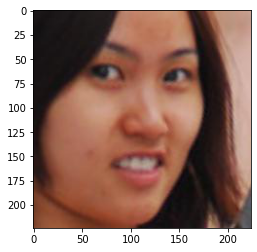

In [116]:
plt.imshow(X_test_reshaped[i])

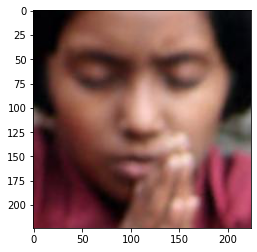

In [110]:
plt.imshow(X_test_reshaped[0])